In [3]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
from scipy import interpolate
import matplotlib as mpl
from tqdm import tqdm
import torchcontrib

### Content  
In this notebook, we show how averaging over many Grad-CAM heatmaps generated from multiple models trained on the same data can lead to improved results on the artifact datasets. The artifact datasets consist of positive and negative classes that are carbon copies of one another, apart from an additional perturbation to the spectra in the positive class. Possibly because of the simple nature of the perturbation, we encounter two flaws with the Grad-CAM scheme. 1) The ***frozen in*** effect, which means that residual attention of the network need not be relinquished so long as the network archives a high classification score. This implies the possibility of misinterpreting lukewarm colors. 2) The ***degenerate minima***, which implies a large set of solutions leading to high accuracy. These datasets appear to be simple to solve and have a wide base of degenerate global minima in terms of classification, however, one solution is not equivalent to another in terms of explainability. Placing the point in the center of this degenerate set should deliver a high degree of interpretability. We, therefore, use a stochastic approach that we call ***Ensemble Grad-CAM*** to overcome these two difficulties. Although the network is randomly initiated for each model, the dataset might bias the final average off of the true loss center, we can therefore only state that given the chance to use a single model or the Ensemble approach, one would statistically achieve better results using the Ensemble method, however it is still possible, although unlikely, to achieve a less perfect explanation. 

It is important to keep in mind that our actual dataset will not be so simple, and therefore it is unclear how afflicted the actual problem is by these two effects. 

In [4]:
method = 'Ensemble Grad-CAM'

#### Create dataloader

In [8]:
class IRISDataSet(Dataset):
    '''
    DataLoader
    '''
    def __init__(self, partition='train'):
        fhand = np.load(f'/data1/userspace/bpanos/XAI/data/artifact/{partition}.npz')
        self.X = torch.Tensor(fhand['X'])
        self.y = torch.Tensor(fhand['y'])

    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, index):
        return self.X[index, :], self.y[index]

#### Create ConvNEt model

In [10]:
class CNN(nn.Module):
    '''
    Simple CNN network with binary output 
    '''
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.num_classes = num_classes
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=2, kernel_size=20, stride=3),
            nn.ReLU(),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=44, out_features=5),
            nn.ReLU(),
            nn.Linear(in_features=5, out_features=self.num_classes)
        )
        
    def forward(self,x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        return self.linear_layers(x)

#### Create hooks that allow us to access the backwards graph and monitor the flow of gradients in the intermediate nodes

In [11]:
class CNN_CAM(nn.Module):
    def __init__(self, net):
        super(CNN_CAM, self).__init__()
        self.conv_layers = nn.Sequential(*list(net.children())[0][:4])
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.linear_layers = nn.Sequential(*list(net.children())[1][:])

    def forward(self, x):
        x = self.conv_layers(x)
        # register hook only in the forward model
        x.register_hook(self.activations_hook)
        # apply the pooling after hook registration
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.linear_layers(x)
        return x

    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.conv_layers(x)

In [12]:
def class_activation_map(model, spectra):
    '''
    Calculate the class activation map following https://arxiv.org/abs/1610.02391
    Inputs
    ------
    model : PyTorch model
        trained with hooks activated on the last convolutional layer
    spectra : PyTorch Tensor
        Spectra of dim (-1, 1, 240) running on the gpu
    Output
    ------
    heatmap : numpy.ndarray
        Rescaled heat-map indicating the most important wavelengths when making its classification
    '''
    model.eval()
    pred = model(spectra)
    pred[:,pred.argmax(dim=1)].backward()
    gradients = model.get_activations_gradient()
    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 1])
    # get the activations of the last convolutional layer
    activations = model.get_activations(spectra).detach()
    
    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :] *= pooled_gradients
    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    heatmap = np.maximum(heatmap.cpu(), 0)
    # rescale heatmap from the size of the feature mask to the size of the spectra
    heatmap = upscale_heatmap(heatmap, spectra)
    # normalize the heatmap
    heatmap = heatmap/max(heatmap)

    return heatmap

def upscale_heatmap(heatmap, spectra):
    x_low = np.linspace(0, spectra.shape[-1], heatmap.shape[-1])
    y_low = heatmap
    f = interpolate.interp1d(x_low, y_low)
    x_high = np.arange(0,spectra.shape[-1],1)
    resized_heatmap = f(x_high)
    return resized_heatmap

#### Define plot function

In [33]:
def plot_res(spectrum, heatmap):
    '''
    Takes in single spectrum and overplots heatmap (no calculations)
    '''
    n_bins = 240
    core_1 = 2796.34
    core_2 = 2803.52
    lambda_min = 2794.14
    lambda_max = 2805.72
    xax = np.linspace( lambda_min, lambda_max, n_bins )

    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 12

    fig, ax = plt.subplots(figsize=(15,5), constrained_layout=False)
    c_grid = np.linspace(0,1,1000)
    gs = fig.add_gridspec(2, 2)
    plt.subplots_adjust(wspace=-.5, hspace=-1)
    colors = plt.cm.jet(c_grid)
    clr = 'k'
    linewidth1 = 2
    linewidth2 = 2
    cmap = mpl.cm.jet

    plt.title(f'{method} for positive classification', fontsize=20)
    plt.ylabel('Normalized Intensity',fontsize=15)
    plt.xlabel('Wavelength (Å)', fontsize=15)
    spectrum = np.squeeze(spectrum.cpu().detach().numpy())
    for i, weight in enumerate(heatmap/max(heatmap)):
        x1, x2 = xax[i], xax[i+1]
        y1, y2 = spectrum[i], spectrum[i +1]
        c_ind = np.argmin( abs(c_grid-weight) )
        plt.plot([x1, x2], [y1, y2], c=colors[c_ind], linewidth=linewidth2)
        if (i > spectrum.shape[0]-3): break
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_minor_locator(MultipleLocator(.5))
    ax.yaxis.set_major_locator(MultipleLocator(.2))
    ax.yaxis.set_minor_locator(MultipleLocator(.2))
    ax.tick_params(which='major', length=10,width=2)
    ax.tick_params(which='minor', length=7,width=2)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical', pad=0.01)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Importance', fontsize=15)

    plt.tight_layout()
    plt.show()

In [34]:
save_path_models = '/data1/userspace/bpanos/XAI/models/ensembl_art/'

#### Train 50 models

In [25]:
for itter in tqdm(range(50)):

    batch_size = 240
    train_dataset = IRISDataSet(partition='train')
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = CNN(num_classes=2).to(device)
    learning_rate = 0.001
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for x, y in train_dataloader:
        x = x.view(-1, 1, x.shape[-1]).to(device)
        y = y.long().to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        
    torch.save(model.state_dict(), f'{save_path_models}{itter}.pt')

    del model, train_dataloader, train_dataset

100%|██████████| 500/500 [1:52:17<00:00, 13.48s/it]


#### Define a plotting function

#### Select a single spectrum from the positive class and calculate the average heatmap over all 500 models 

In [26]:
batch_size = 240
train_dataset = IRISDataSet(partition='train')
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [27]:
# select a single spectrum
ind = 1
spectra, labels = next(iter(train_dataloader))
spectrum, label = spectra[ind], labels[ind]
spectrum = spectrum.to(device).reshape(-1, 1, spectrum.shape[-1])

In [28]:
# Calculate heatmaps for each model and aggregate

heatmaps = []
for model_name in os.listdir(save_path_models):
    path_to_model = save_path_models + model_name
    model = CNN(num_classes=2)
    model.load_state_dict(torch.load(path_to_model))
    model.to(device)
    model.eval();
    
    CNNCam = CNN_CAM(model).to(device)
    heatmap = class_activation_map(CNNCam, spectrum)
    if np.isnan(np.mean(heatmap)): continue
    heatmaps.append( heatmap/ np.nanmax(heatmap) )
    
    del model
    
heatmap = np.vstack(heatmaps)
heatmap = np.nanmean(heatmap, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


#### Plot results from a few single models

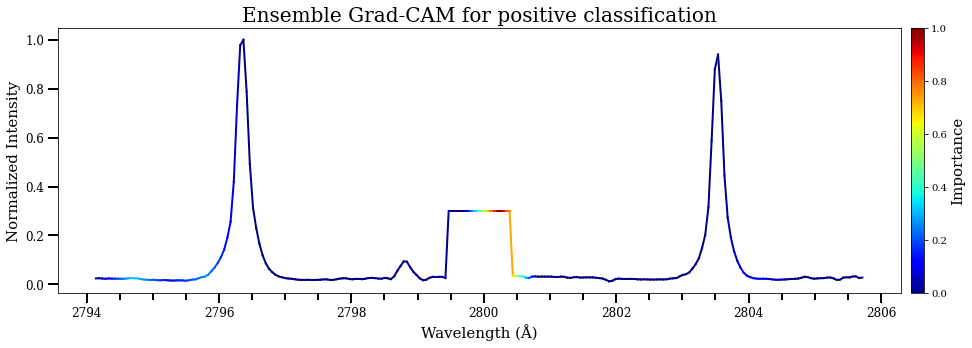

In [38]:
plot_res(spectrum, heatmaps[21])

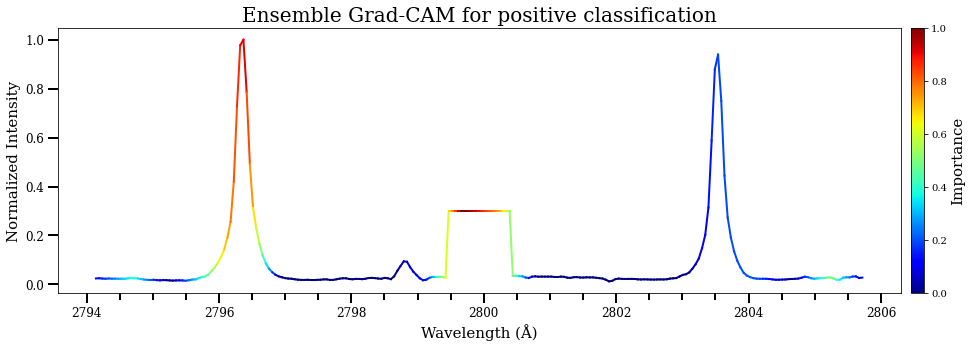

In [40]:
plot_res(spectrum, heatmaps[30])

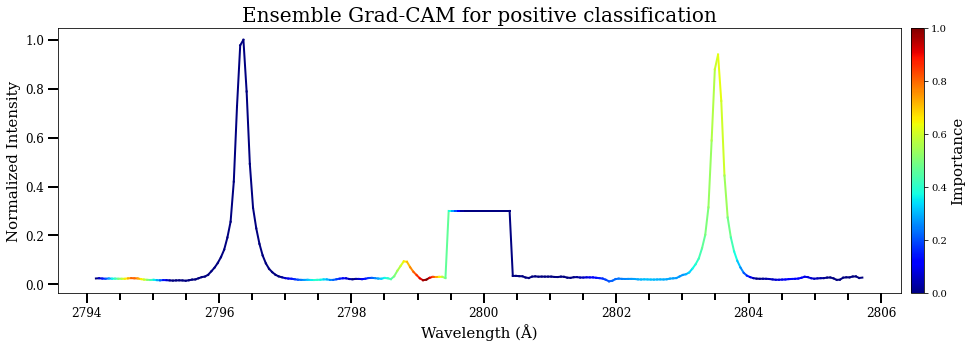

In [39]:
plot_res(spectrum, heatmaps[20])

#### Results from Ensemble

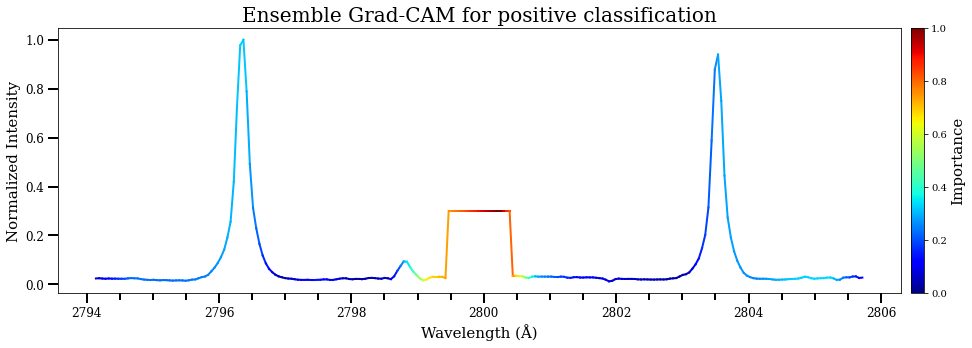

In [41]:
plot_res(spectrum, heatmap)